In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from HD_BET.run import run_hd_bet
from HD_BET.utils import subdirs, subfiles
import sys
import os
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap,
                                MutualInformationMetric,
                                  AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
import nibabel as nib


In [2]:
datadir = "C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2"

SKULL STRIPPING

In [14]:

input_files = []
for dir in subdirs(datadir):
    input_files.extend(subfiles(dir))
output_files = [ifile[:-7]+"_bet.nii.gz" for ifile in input_files]
run_hd_bet(input_files[0:12], output_files[0:12])

File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\ADC_deformed.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\FA_deformed.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\T1w_1mm.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\T2w_1mm_noalign.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\002\ADC_deformed.nii.gz
preprocessing...
image shape after preproces

RIGID REGISTRATION FUNCTION

In [11]:
def registerRigid(fixed, moving, T2, lr, printmetric=False):
    # FA AND ADC REGISTRATION
    initial_transform = sitk.CenteredTransformInitializer(fixed, 
                                                        moving, 
                                                        sitk.Euler3DTransform(),
                                                        sitk.CenteredTransformInitializerFilter.GEOMETRY)

    registration_method = sitk.ImageRegistrationMethod()
    if (T2):
        registration_method.SetMetricAsANTSNeighborhoodCorrelation(radius=2)
    else:
        registration_method.SetMetricAsJointHistogramMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01, 1)

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(learningRate=lr, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    if (printmetric):
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: print('Metric value: {0}'.format(registration_method.GetMetricValue())))
    # Run optimization
    final_transform = registration_method.Execute(fixed, moving)
    # Always check the reason optimization terminated.
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return final_transform

REGISTRATION

In [3]:
def registerimg(fixed, moving, rigid=True, nbins=32,
             sampling_prop=None, level_iters=[10, 10, 5], sigmas = [3.0, 1.0, 0.0],
             factors=[4, 2, 1]):
    # Obtain data array and affine representations
    fixed_data = fixed.get_fdata()
    fixed_affine = fixed.affine
    moving_data = moving.get_fdata()
    moving_affine = moving.affine

    metric = MutualInformationMetric(nbins, sampling_prop)

    # Perform Translation first
    affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)
    transform = TranslationTransform3D()
    translation_reg = affreg.optimize(fixed_data, moving_data, transform, None, fixed_affine, moving_affine)
    # Then full rigid
    transform = RigidTransform3D()
    rigid_reg = affreg.optimize(fixed_data, moving_data, transform, None, fixed_affine, moving_affine, starting_affine=translation_reg.affine)
    # Then full affine, if not just rigid
    if not rigid:
        transform = AffineTransform3D()
        affreg.level_iters = [1000, 1000, 100] # increase iterations for a more exact fit
        affine_reg = affreg.optimize(fixed_data, moving_data, transform, None, fixed_affine, moving_affine, starting_affine=rigid_reg.affine)
        finaltransform = affine_reg
    else:
        finaltransform = rigid_reg
    
    return finaltransform

In [27]:
moving_img = nib.load(os.path.join(datadir, "001", "T2w_1mm_noalign_bet.nii.gz"))
template_img = nib.load(os.path.join(datadir, "001", "T1w_1mm_bet.nii.gz"))
moving_data = moving_img.get_fdata()
moving_affine = moving_img.affine
template_data = template_img.get_fdata()
template_affine = template_img.affine
print(type(moving_data))

<class 'numpy.ndarray'>


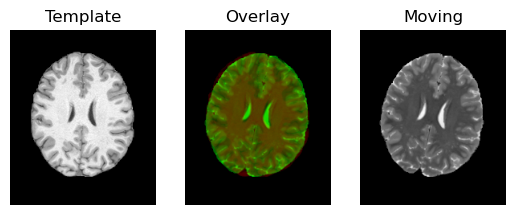

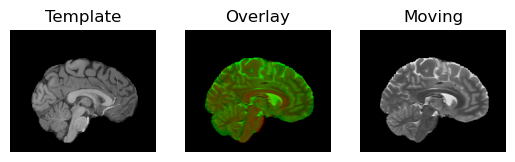

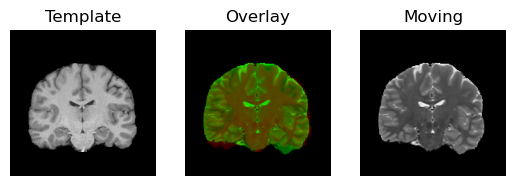

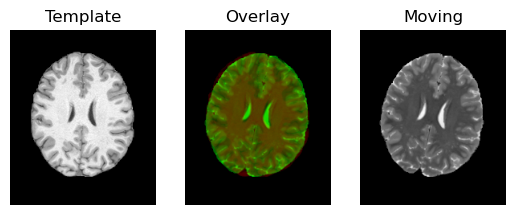

In [19]:
identity = np.eye(4)
affine_map = AffineMap(identity,
                       template_data.shape, template_affine,
                       moving_data.shape, moving_affine)
resampled = affine_map.transform(moving_data)
regtools.overlay_slices(template_data, moving_data, None, 0,
                        "Template", "Moving")

regtools.overlay_slices(template_data, moving_data, None, 1,
                        "Template", "Moving")

regtools.overlay_slices(template_data, moving_data, None, 2,
                        "Template", "Moving")

Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


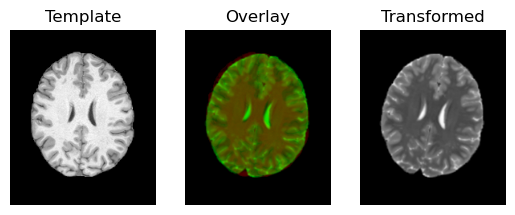

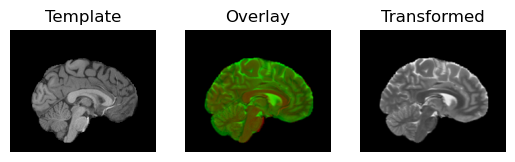

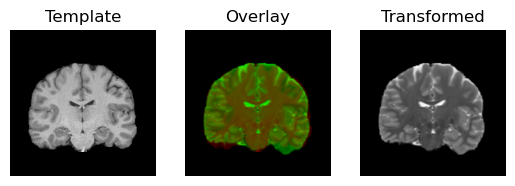

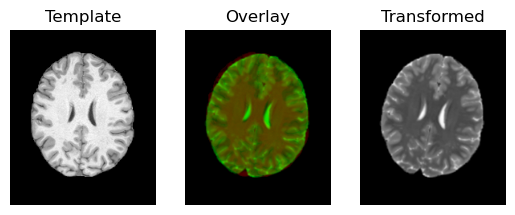

In [20]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)
level_iters = [10, 10, 5]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)
transform = TranslationTransform3D()
translation = affreg.optimize(template_data, moving_data, transform, None, template_affine, moving_affine)
transformed = translation.transform(moving_data)
regtools.overlay_slices(template_data, transformed, None, 0,
                        "Template", "Transformed")

regtools.overlay_slices(template_data, transformed, None, 1,
                        "Template", "Transformed")

regtools.overlay_slices(template_data, transformed, None, 2,
                        "Template", "Transformed")

Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


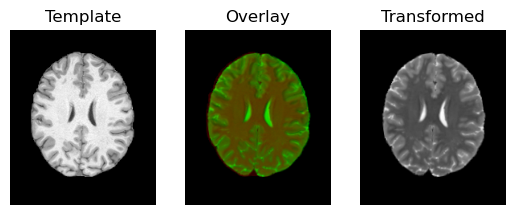

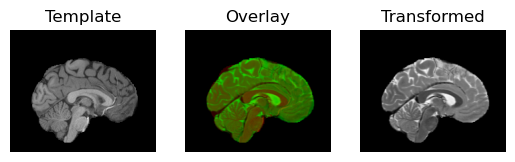

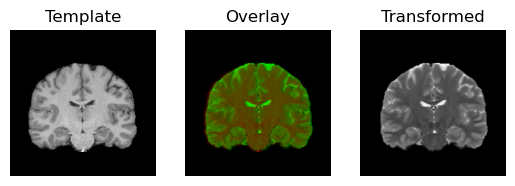

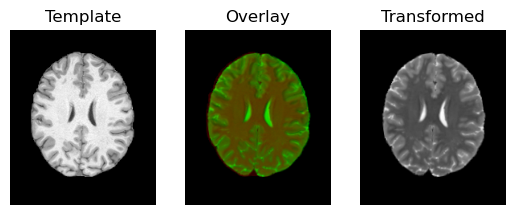

In [22]:
transform = RigidTransform3D()
rigid = affreg.optimize(template_data, moving_data, transform, None, template_affine, moving_affine)
transformed = rigid.transform(moving_data)
regtools.overlay_slices(template_data, transformed, None, 0,
                        "Template", "Transformed")

regtools.overlay_slices(template_data, transformed, None, 1,
                        "Template", "Transformed")

regtools.overlay_slices(template_data, transformed, None, 2,
                        "Template", "Transformed")

REGISTRATION LOOP

In [4]:
slices = [i/10 for i in range(3, 8)] # slices to plot for validation (given as percentage through the height)
showresults = ["001"] # choose the directories to plot the results for
register = True # true if we want to perform registration, otherwise we just want to plot existing registration
for dir in subdirs(datadir):
    # Run only in directories with skull-stripped images
    if dir[-3:] == "001" and os.path.exists(os.path.join(dir, "T1w_1mm_bet.nii.gz")):
        # Show current directory
        print(f"Analyzing images for patient {dir[-3:]}")

        # If we want to perform the registration
        if register:
            # Read in images
            T1w = nib.load(os.path.join(dir, "T1w_1mm_bet.nii.gz"))
            T2w = nib.load(os.path.join(dir, "T2w_1mm_noalign_bet.nii.gz"))
            FA = nib.load(os.path.join(dir, "FA_deformed_bet.nii.gz"))
            ADC = nib.load(os.path.join(dir, "ADC_deformed_bet.nii.gz"))

            transformFA = registerimg(T1w, FA, rigid=False)
            transformADC = registerimg(T1w, ADC, rigid=False)
            transformT2w = registerimg(T1w, T2w, rigid=True)
            T1wdata = T1w.get_fdata()
            FAreg = transformFA.transform(FA)
            ADCreg = transformADC.transform(ADC)
            T2wreg = transformT2w.transform(T2w)
            
            print(FAreg.shape, ADCreg.shape, T2wreg.shape)
            # # Scale FA and ADC to T1w's size
            # FAscaled = sitk.Resample(FA, T1w, sitk.ScaleTransform(3, (1, 1, 1)))
            # ADCscaled = sitk.Resample(ADC, T1w, sitk.ScaleTransform(3, (1, 1, 1)))

            # # Run registration and obtain transformation objects
            # final_transformFA = registerRigid(T1w, FAscaled, T2=False, lr=1.5)
            

            # # Apply the transformation
            # ADCreg = sitk.Resample(ADCscaled, T1w, final_transformFA) # since ADC and FA have same distortion
            # FAreg = sitk.Resample(FAscaled, T1w, final_transformFA)

            # final_transformT2w = registerRigid(ADCreg, T2w, T2=True, lr=1.0, printmetric=True)
            # T2wreg = sitk.Resample(T2w, T1w, final_transformT2w)

            # Scale and save resulting registered images
            # FAreg_ogsize = sitk.Resample(FAreg, FA, sitk.ScaleTransform(3, (1, 1, 1))) # scale FA back to 1.25mm res
            # ADCreg_ogsize = sitk.Resample(ADCreg, ADC, sitk.ScaleTransform(3, (1, 1, 1))) # scale ADC back to 1.25mm res
            # sitk.WriteImage(T2wreg, os.path.join(dir, "T2w_1mm_reg.nii.gz"))
            # sitk.WriteImage(FAreg_ogsize, os.path.join(dir, "FA_reg.nii.gz"))
            # sitk.WriteImage(ADCreg_ogsize, os.path.join(dir, "ADC_reg.nii.gz"))
        # If we just want to display existing registrations:
        else:
            # Ensure registered images exist, then read them in
            if not os.path.exists(os.path.join(dir, "T2w_1mm_reg.nii.gz")):
                print(f"Error: No registration found for patient {dir[-3:]}")
                break
            T1w = sitk.ReadImage(os.path.join(dir, "T1w_1mm_bet.nii.gz"))
            T2wreg = sitk.ReadImage(os.path.join(dir, "T2w_1mm_reg.nii.gz"))
            FAreg_ogsize = sitk.ReadImage(os.path.join(dir, "FA_reg.nii.gz"))
            ADCreg_ogsize = sitk.ReadImage(os.path.join(dir, "ADC_reg.nii.gz"))

        # Confirm sizes are correct
        print(f"FA: {FAreg_ogsize.GetSize()}, ADC: {ADCreg_ogsize.GetSize()}, T2w: {T2wreg.GetSize()}, T1w: {T1w.GetSize()}")

        # Plot the registration results for selected folders
        if dir[-3:] in showresults:
            # # Generate tiles of multiple top-down slices to plot
            # sizediff = FAreg_ogsize.GetSize()[2]
            # sizeT = T1w.GetSize()[2]
            # FAslices = [FAreg_ogsize[:, :, int(s*sizediff)] for s in slices]
            # ADCslices = [ADCreg_ogsize[:, :, int(s*sizediff)] for s in slices]
            # T2wslices = [T2wreg[:, :, int(s*sizeT)] for s in slices]
            # T1wslices = [T1w[:, :, int(s*sizeT)] for s in slices]
            
            # # Convert tiles to arrays for plotting
            # FAarr = sitk.GetArrayFromImage(sitk.Tile(FAslices, [len(slices), 1]))
            # ADCarr = sitk.GetArrayFromImage(sitk.Tile(ADCslices, [len(slices), 1]))
            # T2warr = sitk.GetArrayFromImage(sitk.Tile(T2wslices, [len(slices), 1]))
            # T1warr = sitk.GetArrayFromImage(sitk.Tile(T1wslices, [len(slices), 1]))
            # # print(FAarr.max(), ADCarr.max(), T2warr.max(), T1warr.max())

            # # Plot tiles
            # fig, axs = plt.subplots(4, 1, constrained_layout=True)
            # axs[0].imshow(T1warr, cmap='gray')
            # axs[0].set_title("T1w")
            # axs[1].imshow(T2warr, cmap='gray')
            # axs[1].set_title("T2w Reg.")
            # axs[2].imshow(FAarr, cmap='gray')
            # axs[2].set_title("FA Reg.")
            # axs[3].imshow(ADCarr, cmap='gray')
            # axs[3].set_title("ADC Reg.")
            # fig.suptitle(f"Registration for patient {dir[-3:]}")
            # fig.set_dpi(300)
            regtools.overlay_slices(T1wdata, T2wreg, None, 1,
                        "T1w", "T2w reg")

            regtools.overlay_slices(T1wdata, FAreg, None, 1,
                                    "T1w", "FA reg")

            regtools.overlay_slices(T1wdata, ADCreg, None, 1,
                                    "T1w", "ADc reg")

Analyzing images for patient 001
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


AttributeError: 'Nifti1Image' object has no attribute 'astype'

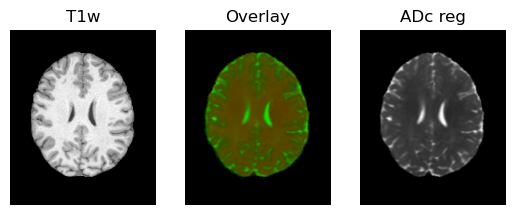

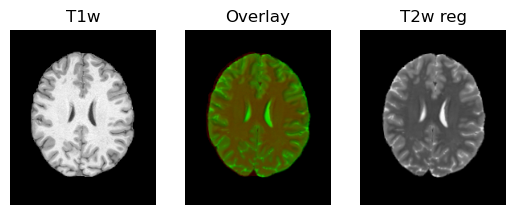

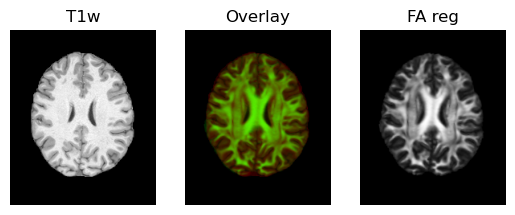

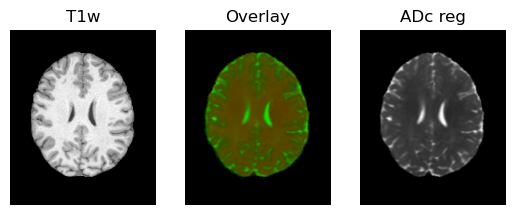

In [6]:
T1wdata = T1w.get_fdata()
FAdata = FA.get_fdata()
ADCdata = ADC.get_fdata()
T2wdata = T2w.get_fdata()
FAreg = transformFA.transform(FAdata)
ADCreg = transformADC.transform(ADCdata)
T2wreg = transformT2w.transform(T2wdata)
regtools.overlay_slices(T1wdata, T2wreg, None, 2,
                        "T1w", "T2w reg")

regtools.overlay_slices(T1wdata, FAreg, None, 2,
                        "T1w", "FA reg")

regtools.overlay_slices(T1wdata, ADCreg, None, 2,
                        "T1w", "ADc reg")

In [7]:
FAnew = nib.Nifti1Image(FAreg, FA.affine, FA.header)
nib.save(FAnew, os.path.join(datadir, "001", "FA_reg.nii.gz"))
ADCnew = nib.Nifti1Image(ADCreg, ADC.affine, ADC.header)
nib.save(ADCnew, os.path.join(datadir, "001", "ADC_reg.nii.gz"))
T2wnew = nib.Nifti1Image(T2wreg, T2w.affine, T2w.header)
nib.save(T2wnew, os.path.join(datadir, "001", "T2w_reg.nii.gz"))

In [31]:
print(FAreg.GetSize()[0])
sitk.Show(FAreg)

182


RuntimeError: Exception thrown in SimpleITK Show: D:\a\1\sitk\Code\IO\src\sitkImageViewer.cxx:620:
sitk::ERROR: No ImageJ/Fiji application found.